![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [116]:
import warnings
warnings.filterwarnings('ignore')

In [117]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [118]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [119]:
# Se revisan las dimensiones de los df
print(dataTraining.shape)
print(dataTesting.shape)

(7895, 5)
(3383, 3)


In [120]:
# Se eliminan los registros repetidos
dataTraining = dataTraining.drop_duplicates()
dataTraining.shape

(7894, 5)

In [121]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [122]:
dataTraining.loc[2582]

year                                                   1990
title                                         Narrow Margin
plot      in los angeles ,  the editor of a publishing h...
genres                      ['Action', 'Crime', 'Thriller']
rating                                                  6.6
Name: 2582, dtype: object

In [124]:
# Visualización datos de test
dataTesting.head(10)

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...
9,1961,Barabbas,"epic account of the thief barabbas , who was ..."
11,2005,Rize,reveals a groundbreaking dance phenomenon that...
13,2000,The Yards,"in the rail yards of queens , contractors rep..."
16,1992,Used People,"at her husband ' s funeral , pearl ( shirley..."
21,2004,My Baby's Daddy,"lonnie , dominic and ' g ' are three bachel..."


Se inspecciona los textos para verificar si se debe realizar limpieza:

In [125]:
dataTraining['plot']

3107    most is the story of a single father who takes...
900     a serial killer decides to teach the secrets o...
6724    in sweden ,  a female blackmailer with a disfi...
4704    in a friday afternoon in new york ,  the presi...
2582    in los angeles ,  the editor of a publishing h...
                              ...                        
8417    " our marriage ,  their wedding .  "  it ' s l...
1592    the wandering barbarian ,  conan ,  alongside ...
1723    like a tale spun by scheherazade ,  kismet fol...
7605    mrs .  brisby ,  a widowed mouse ,  lives in a...
215     tinker bell journey far north of never land to...
Name: plot, Length: 7894, dtype: object

In [126]:
dataTraining['plot'][0]

"major benson winifred payne is being discharged from the marines .  payne is a killin '  machine ,  but the wars of the world are no longer fought on the battlefield .  a career marine ,  he has no idea what to do as a civilian ,  so his commander finds him a job  -  commanding officer of a local school ' s jrotc program ,  a bunch or ragtag losers with no hope .  using such teaching tools as live grenades and real bullets ,  payne starts to instill the corp with some hope .  but when payne is recalled to fight in bosnia ,  will he leave the corp that has just started to believe in him ,  or will he find out that killin '  ain ' t much of a livin '  ?"

In [127]:
dataTraining['plot'][3107]

'most is the story of a single father who takes his eight year - old son to work with him at the railroad drawbridge where he is the bridge tender .  a day before ,  the boy meets a woman boarding a train ,  a drug abuser .  at the bridge ,  the father goes into the engine room ,  and tells his son to stay at the edge of the nearby lake .  a ship comes ,  and the bridge is lifted .  though it is supposed to arrive an hour later ,  the train happens to arrive .  the son sees this ,  and tries to warn his father ,  who is not able to see this .  just as the oncoming train approaches ,  his son falls into the drawbridge gear works while attempting to lower the bridge ,  leaving the father with a horrific choice .  the father then lowers the bridge ,  the gears crushing the boy .  the people in the train are completely oblivious to the fact a boy died trying to save them ,  other than the drug addict woman ,  who happened to look out her train window .  the movie ends ,  with the man wande

In [128]:
dataTraining['plot'][8417]

'" our marriage ,  their wedding .  "  it \' s lesson number one for any newly engaged couple ,  and lucia and marcus are no exception .  in our family wedding ,  they learn the hard way that the path to saying  " i do "  can be rife with familial strife .  when they return from college and too suddenly announce their marriage plans ,  they soon discover that their fathers  -  two highly competitive over - the - top egos  -  can wreak a major amount of havoc on their special day .  with insults flying and tempers running high ,  it \' s anyone \' s guess if the alpha dads will survive to make it down the aisle in one piece .  lucia \' s mother is busy planning the wedding of  " her "  dreams and the only levelheaded one in the bunch is angela ,  the groom \' s father \' s best friend and lawyer ,  who manages to keep her cool when the madness reaches a crescendo .  with only weeks to plan their wedding ,  lucia and marcus soon discover the true meaning of love and find there is truth t

Se observan stopwords, signos de puntuación, comillas, signos de interrogación. Por esto se procede a eliminarlos para mejorar el performance del modelo

In [129]:
import re

def limpieza_texto(texto):
    # removiendo caracteres especiales que pueda contener el texto
    patron = r'[^a-zA-Z0-9\s]'
    texto = re.sub(patron, ' ', texto)
    # eliminar espacios adicionales entre texto
    texto = ' '.join(texto.split()) 
    # Convertir todo el texto en minúscula
    texto = texto.lower()
    # Se remueve backslash
    texto = re.sub("\'", "", texto)

    return texto


In [130]:
# Aplicando la limpieza en el texto en los dos set
dataTraining['plot_limpio'] = dataTraining['plot'].apply(lambda x: limpieza_texto(x))
dataTesting['plot_limpio'] = dataTesting['plot'].apply(lambda x: limpieza_texto(x))

In [131]:
dataTraining

,year,title,plot,genres,rating,plot_limpio
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,most is the story of a single father who takes...
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,a serial killer decides to teach the secrets o...
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,in sweden a female blackmailer with a disfigur...
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,in a friday afternoon in new york the presiden...
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,in los angeles the editor of a publishing hous...
...,...,...,...,...,...,...
8417,2010,Our Family Wedding,""" our marriage , their wedding . "" it ' s l...","['Comedy', 'Romance']",4.9,our marriage their wedding it s lesson number ...
1592,1984,Conan the Destroyer,"the wandering barbarian , conan , alongside ...","['Action', 'Adventure', 'Fantasy']",5.8,the wandering barbarian conan alongside his go...
1723,1955,Kismet,"like a tale spun by scheherazade , kismet fol...","['Adventure', 'Musical', 'Fantasy', 'Comedy', ...",6.4,like a tale spun by scheherazade kismet follow...
7605,1982,The Secret of NIMH,"mrs . brisby , a widowed mouse , lives in a...","['Animation', 'Adventure', 'Drama', 'Family', ...",7.6,mrs brisby a widowed mouse lives in a cinder b...


In [132]:
dataTesting

,year,title,plot,plot_limpio
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ....",who meets by fate shall be sealed by fate ther...
4,1978,Midnight Express,"the true story of billy hayes , an american c...",the true story of billy hayes an american coll...
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...,martin vail left the chicago da s office to be...
6,1950,Crisis,husband and wife americans dr . eugene and mr...,husband and wife americans dr eugene and mrs h...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...,the coroner and scientist dr warren chapin is ...
...,...,...,...,...
11263,2008,The Fifth Commandment,"in bangkok , an assassin who turns down a job...",in bangkok an assassin who turns down a job th...
11265,2003,Coffee and Cigarettes,eleven separate vignettes are presented . in ...,eleven separate vignettes are presented in eac...
11269,1957,Pal Joey,"joey evans is charming , handsome , funny , ...",joey evans is charming handsome funny talented...
11270,2002,Jonah: A VeggieTales Movie,when the singing veggies encounter some car tr...,when the singing veggies encounter some car tr...


Se revisa nuevamente el texto para validar si desaparecieron la mayoría de carácteres especiales

In [133]:
dataTraining['plot_limpio'][0]

'major benson winifred payne is being discharged from the marines payne is a killin machine but the wars of the world are no longer fought on the battlefield a career marine he has no idea what to do as a civilian so his commander finds him a job commanding officer of a local school s jrotc program a bunch or ragtag losers with no hope using such teaching tools as live grenades and real bullets payne starts to instill the corp with some hope but when payne is recalled to fight in bosnia will he leave the corp that has just started to believe in him or will he find out that killin ain t much of a livin'

In [134]:
dataTraining['plot_limpio'][8417]

'our marriage their wedding it s lesson number one for any newly engaged couple and lucia and marcus are no exception in our family wedding they learn the hard way that the path to saying i do can be rife with familial strife when they return from college and too suddenly announce their marriage plans they soon discover that their fathers two highly competitive over the top egos can wreak a major amount of havoc on their special day with insults flying and tempers running high it s anyone s guess if the alpha dads will survive to make it down the aisle in one piece lucia s mother is busy planning the wedding of her dreams and the only levelheaded one in the bunch is angela the groom s father s best friend and lawyer who manages to keep her cool when the madness reaches a crescendo with only weeks to plan their wedding lucia and marcus soon discover the true meaning of love and find there is truth to the saying that when you marry someone you marry their entire family'

Se visualiza un poco más limpio el texto, ahora se intenta eliminar las stopwords de la siguiente manera:

In [135]:
import nltk
from nltk.corpus import stopwords
#nltk.download('punkt')


def eliminar_stopwords(texto):
    # Obtener las stopwords en inglés
    stopwords_lista = stopwords.words('english')
    
    # Tokenizar el texto en palabras
    palabras = nltk.word_tokenize(texto)
    
    # Filtrar las palabras que no son stopwords
    palabras_filtradas = [palabra for palabra in palabras if palabra.lower() not in stopwords_lista]
    
    # Unir las palabras filtradas en un nuevo texto
    texto_filtrado = ' '.join(palabras_filtradas)
    
    return texto_filtrado



In [136]:
dataTraining['plot_limpio'] = dataTraining['plot_limpio'].apply(lambda x: eliminar_stopwords(x))
dataTesting['plot_limpio'] = dataTesting['plot_limpio'].apply(lambda x: eliminar_stopwords(x))

In [137]:
dataTraining

,year,title,plot,genres,rating,plot_limpio
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,story single father takes eight year old son w...
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,serial killer decides teach secrets satisfying...
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,sweden female blackmailer disfiguring facial s...
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,friday afternoon new york president tredway co...
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,los angeles editor publishing house carol hunn...
...,...,...,...,...,...,...
8417,2010,Our Family Wedding,""" our marriage , their wedding . "" it ' s l...","['Comedy', 'Romance']",4.9,marriage wedding lesson number one newly engag...
1592,1984,Conan the Destroyer,"the wandering barbarian , conan , alongside ...","['Action', 'Adventure', 'Fantasy']",5.8,wandering barbarian conan alongside goofy rogu...
1723,1955,Kismet,"like a tale spun by scheherazade , kismet fol...","['Adventure', 'Musical', 'Fantasy', 'Comedy', ...",6.4,like tale spun scheherazade kismet follows rem...
7605,1982,The Secret of NIMH,"mrs . brisby , a widowed mouse , lives in a...","['Animation', 'Adventure', 'Drama', 'Family', ...",7.6,mrs brisby widowed mouse lives cinder block ch...


In [138]:
dataTesting

,year,title,plot,plot_limpio
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ....",meets fate shall sealed fate theresa osborne r...
4,1978,Midnight Express,"the true story of billy hayes , an american c...",true story billy hayes american college studen...
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...,martin vail left chicago da office become succ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...,husband wife americans dr eugene mrs helen fer...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...,coroner scientist dr warren chapin researching...
...,...,...,...,...
11263,2008,The Fifth Commandment,"in bangkok , an assassin who turns down a job...",bangkok assassin turns job hits close home fin...
11265,2003,Coffee and Cigarettes,eleven separate vignettes are presented . in ...,eleven separate vignettes presented celebritie...
11269,1957,Pal Joey,"joey evans is charming , handsome , funny , ...",joey evans charming handsome funny talented fi...
11270,2002,Jonah: A VeggieTales Movie,when the singing veggies encounter some car tr...,singing veggies encounter car trouble stranded...


Se revira nuevamente si se eliminaron las stopwords

In [139]:
dataTraining['plot_limpio'][0]

'major benson winifred payne discharged marines payne killin machine wars world longer fought battlefield career marine idea civilian commander finds job commanding officer local school jrotc program bunch ragtag losers hope using teaching tools live grenades real bullets payne starts instill corp hope payne recalled fight bosnia leave corp started believe find killin much livin'

In [140]:
dataTraining['genres'][0]

"['Adventure', 'Comedy', 'Family']"

In [141]:
dataTraining['plot_limpio'][8417]

'marriage wedding lesson number one newly engaged couple lucia marcus exception family wedding learn hard way path saying rife familial strife return college suddenly announce marriage plans soon discover fathers two highly competitive top egos wreak major amount havoc special day insults flying tempers running high anyone guess alpha dads survive make aisle one piece lucia mother busy planning wedding dreams levelheaded one bunch angela groom father best friend lawyer manages keep cool madness reaches crescendo weeks plan wedding lucia marcus soon discover true meaning love find truth saying marry someone marry entire family'

Ahora se visualiza cuantas clases se encuentran en la variable de respuesta:

In [142]:
valores = pd.DataFrame(dataTraining['genres'].value_counts())
valores

,genres
['Drama'],429
['Comedy'],368
"['Comedy', 'Drama', 'Romance']",306
"['Comedy', 'Romance']",291
"['Comedy', 'Drama']",287
...,...
"['Animation', 'Drama', 'Music']",1
"['Action', 'Adventure', 'Comedy', 'Fantasy', 'Thriller']",1
"['Action', 'Adventure', 'Crime', 'Drama', 'Sci-Fi']",1
"['Drama', 'Action', 'Crime']",1


In [143]:
valores.shape

(1336, 1)

In [144]:
len(valores[valores['genres']>10])

128

Existen clases con muy pocos valores representados. Es decir, sólo existen  128 grupo de generos que se repiten más de 10 veces.

In [145]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

Se crea un DF para revisar por genero las películas a las que pertenece

In [146]:
y_genres_df = pd.DataFrame(data=y_genres, columns = le.classes_)
y_genres_df.sum()

Action         1302
Adventure      1023
Animation       259
Biography       373
Comedy         3046
Crime          1447
Documentary     419
Drama          3965
Family          681
Fantasy         706
Film-Noir       168
History         273
Horror          954
Music           341
Musical         271
Mystery         759
News              7
Romance        1892
Sci-Fi          723
Short            92
Sport           261
Thriller       2024
War             348
Western         237
dtype: int64

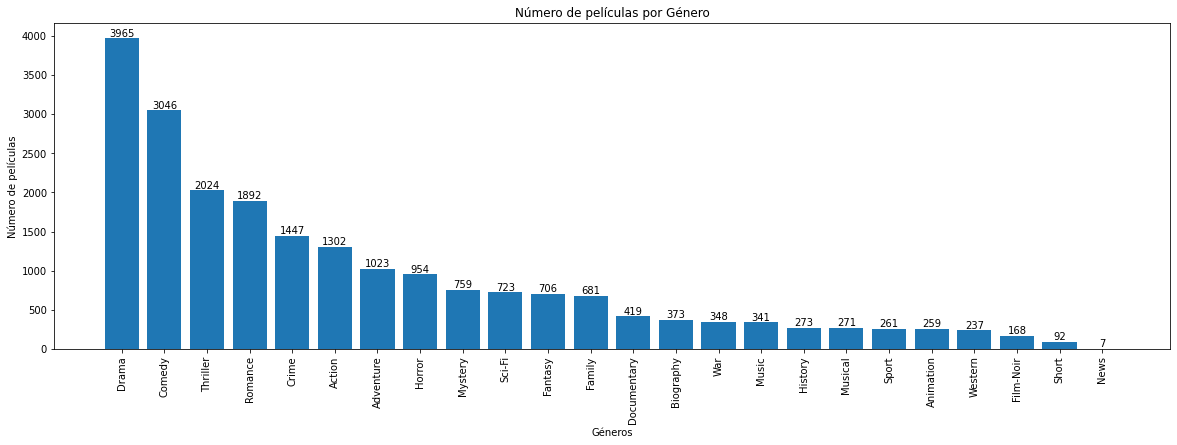

In [147]:
import matplotlib.pyplot as plt

# Calcular la suma por columna
suma_por_columna = y_genres_df.sum()

# Ordenar las barras en orden descendente
suma_por_columna = suma_por_columna.sort_values(ascending=False)

# Obtener las etiquetas de las columnas
etiquetas = suma_por_columna.index

# Obtener los valores de la suma por columna
valores = suma_por_columna.values

# Aumentar el tamaño de la gráfica
plt.figure(figsize=(20, 6))

# Graficar el gráfico de barras
plt.bar(etiquetas, valores)

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Añadir etiquetas a los ejes
plt.xlabel('Géneros')
plt.ylabel('Número de películas')
plt.title('Número de películas por Género')

# Agregar etiquetas en la parte superior de las barras
for i, v in enumerate(valores):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom')

# Mostrar el gráfico
plt.show()




In [148]:
y_genres_df

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7889,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7890,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7891,0,1,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
7892,0,1,1,0,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0


Ahora se procede a vectorizar los textos y modelarlos:

## 1 Forma  CountVectorizer(max_features=1000)

In [33]:
# Definición de variables predictoras (X)
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot_limpio'])
X_dtm.shape

(7894, 1000)

In [34]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

RF

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [43]:
clf = OneVsRestClassifier(RandomForestClassifier(random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_rf = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf, average='macro')

0.7423027381133265

In [37]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_rf = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf, average='macro')

0.7719387868973243

In [ ]:
# Optimización con GridSearchCV
# Definir los parámetros que deseas probar
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [5, 50, 100]
}

# Crear el clasificador y el objeto GridSearchCV
clf2 = OneVsRestClassifier(RandomForestClassifier())
grid_search = GridSearchCV(clf2, param_grid, cv=5)

# Entrenar el clasificador con GridSearchCV
grid_search.fit(X_train, y_train_genres)

# Obtener los mejores parámetros y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados: ", best_params)
print("Mejor puntuación encontrada: {:.2f}".format(best_score))

# Entrenar el clasificador con los mejores parámetros
clf2 = OneVsRestClassifier(RandomForestClassifier(n_estimators=best_params['estimator__n_estimators'], 
                                                  max_depth=best_params['estimator__max_depth']))
clf2.fit(X_train, y_train_genres)


# Predicción del modelo de clasificación
y_pred_genres_rf2 = clf2.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf2, average='macro')

XGBoost

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, 
                                          n_jobs=-1, random_state=42))

xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

0.7970435711317966

In [40]:
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, 
                                          learning_rate=0.19,n_estimators=100, n_jobs=-1, random_state=42))

xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

0.800963247778852

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Definir los parámetros que deseas probar
param_grid = {
    'estimator__learning_rate': [0.01, 0.1, 0.2],  # Prueba diferentes tasas de aprendizaje
    'estimator__n_estimators': [100, 200, 300],  # Prueba diferentes números de estimadores
    'estimator__max_depth': [3, 5, 7],  # Prueba diferentes profundidades máximas
    'estimator__subsample': [0.8, 1.0],  # Prueba diferentes proporciones de submuestreo
    'estimator__colsample_bytree': [0.8, 1.0],  # Prueba diferentes proporciones de columnas utilizadas por árbol
    'estimator__gamma': [0, 0.1, 0.2]  # Prueba diferentes valores de gamma
}

# Crear el clasificador y el objeto GridSearchCV
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42))
grid_search = GridSearchCV(xgb_p, param_grid, cv=5)

# Entrenar el clasificador con GridSearchCV
grid_search.fit(X_train, y_train_genres)

# Obtener los mejores parámetros y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados: ", best_params)
print("Mejor puntuación encontrada: {:.2f}".format(best_score))

# Entrenar el clasificador con los mejores parámetros
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42, **best_params))
xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

RL

In [41]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l1')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.7941351379552207

In [42]:
lr = LogisticRegression(solver='liblinear', penalty='l2')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.7970895797511588

Resultados de los modelos


Forma        |Modelo                        | AUC      |
-------------|------------------------------|----------|
 1 Forma     |Random Forest Sin optimizar   | 0.7423   |
 1 Forma     |Random Forest con parámetros  | 0.7719   |
 1 Forma     |Random Forest con GridSearch  | 0.7900   |
 1 Forma     |XGBoost  Sin optimizar        | 0.7970   |
 1 Forma     |XGBoost  con parámetros       | 0.8009   |
 1 Forma     |XGBoost  con GridSearch       | 0.8100   |
 1 Forma     |Regresión Logística  (L1)     | 0.7941   |
 1 Forma     |Regresión Logística  (L2)     | 0.7970   |

## 2 Forma  TfidfVectorizer(min_df=3, max_features=9000)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=3, max_features=9000)
X_dtm = vect.fit_transform(dataTraining['plot_limpio'])
X_dtm.shape

(7894, 9000)

In [45]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

RF

In [46]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_rf = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf, average='macro')

0.8035258469063482

In [47]:

clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_rf = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf, average='macro')

0.8127617727802602

In [ ]:
# Optimización con GridSearchCV
# Definir los parámetros que deseas probar
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [5, 10, 15]
}

# Crear el clasificador y el objeto GridSearchCV
clf2 = OneVsRestClassifier(RandomForestClassifier())
grid_search = GridSearchCV(clf2, param_grid, cv=5)

# Entrenar el clasificador con GridSearchCV
grid_search.fit(X_train, y_train_genres)

# Obtener los mejores parámetros y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados: ", best_params)
print("Mejor puntuación encontrada: {:.2f}".format(best_score))

In [ ]:
# Entrenar el clasificador con los mejores parámetros
clf2 = OneVsRestClassifier(RandomForestClassifier(n_estimators=best_params['estimator__n_estimators'], max_depth=best_params['estimator__max_depth']))
clf2.fit(X_train, y_train_genres)


# Predicción del modelo de clasificación
y_pred_genres_rf2 = clf2.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf2, average='macro')

XGBoost

In [48]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, n_jobs=-1, random_state=42))

xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

0.8175299619675972

In [50]:
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, learning_rate=0.19,n_estimators=100, n_jobs=-1, random_state=42))

xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

0.817741632192174

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Definir los parámetros que deseas probar
param_grid = {
    'estimator__learning_rate': [0.01, 0.1, 0.2],  # Prueba diferentes tasas de aprendizaje
    'estimator__n_estimators': [100, 200, 300],  # Prueba diferentes números de estimadores
    'estimator__max_depth': [3, 5, 7],  # Prueba diferentes profundidades máximas
    'estimator__subsample': [0.8, 1.0],  # Prueba diferentes proporciones de submuestreo
    'estimator__colsample_bytree': [0.8, 1.0],  # Prueba diferentes proporciones de columnas utilizadas por árbol
    'estimator__gamma': [0, 0.1, 0.2]  # Prueba diferentes valores de gamma
}

# Crear el clasificador y el objeto GridSearchCV
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42))
grid_search = GridSearchCV(xgb_p, param_grid, cv=5)

# Entrenar el clasificador con GridSearchCV
grid_search.fit(X_train, y_train_genres)

# Obtener los mejores parámetros y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados: ", best_params)
print("Mejor puntuación encontrada: {:.2f}".format(best_score))

# Entrenar el clasificador con los mejores parámetros
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42, **best_params))
xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

LR

In [51]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l1')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.7890145401906041

In [52]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l2')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.8786574847883614

Resultados de los modelos


Forma        |Modelo                        | AUC      |
-------------|------------------------------|----------|
 2 Forma     |Random Forest Sin optimizar   | 0.8035   |
 2 Forma     |Random Forest con parámetros  | 0.8127   |
 2 Forma     |Random Forest con GridSearch  | 0.8070   |
 2 Forma     |XGBoost  Sin optimizar        | 0.8175   |
 2 Forma     |XGBoost  con parámetros       | 0.8177   |
 2 Forma     |XGBoost  con GridSearch       | 0.8205   |
 2 Forma     |Regresión Logística (L1)      | 0.7890   |
 2 Forma     |Regresión Logística (L2)      | 0.8786   |

## 3 Forma  TfidfVectorizer(max_df=0.2, sublinear_tf=True, smooth_idf=False, max_features=20000)

In [53]:
vect = TfidfVectorizer(max_df=0.2, sublinear_tf=True, smooth_idf=False, max_features=20000)
X_dtm = vect.fit_transform(dataTraining['plot_limpio'])
X_dtm.shape

(7894, 20000)

In [54]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

RF

In [55]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_rf = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf, average='macro')

0.8053650178768135

In [56]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_rf = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf, average='macro')

0.7928198745741016

In [ ]:
# Optimización con GridSearchCV
# Definir los parámetros que deseas probar
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [5, 10, 15]
}

# Crear el clasificador y el objeto GridSearchCV
clf2 = OneVsRestClassifier(RandomForestClassifier())
grid_search = GridSearchCV(clf2, param_grid, cv=5)

# Entrenar el clasificador con GridSearchCV
grid_search.fit(X_train, y_train_genres)

# Obtener los mejores parámetros y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados: ", best_params)
print("Mejor puntuación encontrada: {:.2f}".format(best_score))

In [ ]:
# Entrenar el clasificador con los mejores parámetros
clf2 = OneVsRestClassifier(RandomForestClassifier(n_estimators=best_params['estimator__n_estimators'], max_depth=best_params['estimator__max_depth']))
clf2.fit(X_train, y_train_genres)


# Predicción del modelo de clasificación
y_pred_genres_rf2 = clf2.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf2, average='macro')

XGBoost

In [57]:
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, n_jobs=-1, random_state=42))

xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

0.8204685848519356

In [58]:
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, learning_rate=0.19,n_estimators=100, n_jobs=-1, random_state=42))

xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

0.822602656090598

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Definir los parámetros que deseas probar
param_grid = {
    'estimator__learning_rate': [0.01, 0.1, 0.2],  # Prueba diferentes tasas de aprendizaje
    'estimator__n_estimators': [100, 200, 300],  # Prueba diferentes números de estimadores
    'estimator__max_depth': [3, 5, 7],  # Prueba diferentes profundidades máximas
    'estimator__subsample': [0.8, 1.0],  # Prueba diferentes proporciones de submuestreo
    'estimator__colsample_bytree': [0.8, 1.0],  # Prueba diferentes proporciones de columnas utilizadas por árbol
    'estimator__gamma': [0, 0.1, 0.2]  # Prueba diferentes valores de gamma
}

# Crear el clasificador y el objeto GridSearchCV
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42))
grid_search = GridSearchCV(xgb_p, param_grid, cv=5)

# Entrenar el clasificador con GridSearchCV
grid_search.fit(X_train, y_train_genres)

# Obtener los mejores parámetros y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados: ", best_params)
print("Mejor puntuación encontrada: {:.2f}".format(best_score))

# Entrenar el clasificador con los mejores parámetros
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42, **best_params))
xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

LR

In [59]:
lr = LogisticRegression(solver='liblinear', penalty='l1')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.7825841059400348

In [60]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l2')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.8880733667026636

Forma        |Modelo                        | AUC      |
-------------|------------------------------|----------|
 3 Forma     |Random Forest Sin optimizar   | 0.8053   |
 3 Forma     |Random Forest con parámetros  | 0.7928   |
 3 Forma     |Random Forest con GridSearch  | 0.7625   |
 3 Forma     |XGBoost  Sin optimizar        | 0.8204   |
 3 Forma     |XGBoost  con parámetros       | 0.8226   |
 3 Forma     |XGBoost  con GridSearch       | 0.8356   |
 3 Forma     |Regresión Logística  (L1)     | 0.7825   |
 3 Forma     |Regresión Logística  (L2)     | 0.8880   |

## 4 Forma  TfidfVectorizer(max_df=0.2, sublinear_tf=True, smooth_idf=True, max_features=20000)

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_df=0.2, sublinear_tf=True, smooth_idf=True, max_features=20000)
X_dtm = vect.fit_transform(dataTraining['plot_limpio'])
X_dtm.shape

(7894, 20000)

In [62]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

RF

In [63]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_rf = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf, average='macro')

0.8076296374102103

In [64]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_rf = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf, average='macro')

0.7954099251842868

In [ ]:
# Optimización con GridSearchCV
# Definir los parámetros que deseas probar
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [5, 10, 15]
}

# Crear el clasificador y el objeto GridSearchCV
clf2 = OneVsRestClassifier(RandomForestClassifier())
grid_search = GridSearchCV(clf2, param_grid, cv=5)

# Entrenar el clasificador con GridSearchCV
grid_search.fit(X_train, y_train_genres)

# Obtener los mejores parámetros y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados: ", best_params)
print("Mejor puntuación encontrada: {:.2f}".format(best_score))

In [ ]:
# Entrenar el clasificador con los mejores parámetros
clf2 = OneVsRestClassifier(RandomForestClassifier(n_estimators=best_params['estimator__n_estimators'], max_depth=best_params['estimator__max_depth']))
clf2.fit(X_train, y_train_genres)


# Predicción del modelo de clasificación
y_pred_genres_rf2 = clf2.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf2, average='macro')

XGBoot

In [65]:
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, n_jobs=-1, random_state=42))

xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

0.8207120577031968

In [66]:
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, learning_rate=0.19,n_estimators=100, n_jobs=-1, random_state=42))

xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

0.821255083052935

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Definir los parámetros que deseas probar
param_grid = {
    'estimator__learning_rate': [0.01, 0.1, 0.2],  # Prueba diferentes tasas de aprendizaje
    'estimator__n_estimators': [100, 200, 300],  # Prueba diferentes números de estimadores
    'estimator__max_depth': [3, 5, 7],  # Prueba diferentes profundidades máximas
    'estimator__subsample': [0.8, 1.0],  # Prueba diferentes proporciones de submuestreo
    'estimator__colsample_bytree': [0.8, 1.0],  # Prueba diferentes proporciones de columnas utilizadas por árbol
    'estimator__gamma': [0, 0.1, 0.2]  # Prueba diferentes valores de gamma
}

# Crear el clasificador y el objeto GridSearchCV
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42))
grid_search = GridSearchCV(xgb_p, param_grid, cv=5)

# Entrenar el clasificador con GridSearchCV
grid_search.fit(X_train, y_train_genres)

# Obtener los mejores parámetros y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados: ", best_params)
print("Mejor puntuación encontrada: {:.2f}".format(best_score))

# Entrenar el clasificador con los mejores parámetros
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42, **best_params))
xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

LR

In [68]:
lr = LogisticRegression(solver='liblinear', penalty='l1')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.7836421417766996

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Crear una instancia del estimador interno LogisticRegression con los mejores parámetros
lr = LogisticRegression(solver='liblinear', penalty='l1', C=0.6)

# Crear una instancia de OneVsRestClassifier con el estimador interno LogisticRegression
clf = OneVsRestClassifier(lr)

# Ajustar el modelo a los datos de entrenamiento
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.7335249401894988

In [67]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l2')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.8880354151022415

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Crear una instancia del estimador interno LogisticRegression con los mejores parámetros
lr = LogisticRegression(solver='liblinear', penalty='l2', C=0.6)

# Crear una instancia de OneVsRestClassifier con el estimador interno LogisticRegression
clf = OneVsRestClassifier(lr)

# Ajustar el modelo a los datos de entrenamiento
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.888492754280937

Forma        |Modelo                        | AUC      |
-------------|------------------------------|----------|
 4 Forma     |Random Forest Sin optimizar   | 0.8076   |
 4 Forma     |Random Forest con parámetros  | 0.7954   |
 4 Forma     |Random Forest con GridSearch  | 0.8500   |
 4 Forma     |XGBoost  Sin optimizar        | 0.8207   |
 4 Forma     |XGBoost  con parámetros       | 0.8212   |
 4 Forma     |XGBoost  con GridSearch       | 0.8423   |
 4 Forma     |Regresión Logística (L1)      | 0.7833   |
 4 Forma     |Regresión Logística (L2)      | 0.8880   |
 4 Forma     |Regresión Logística (L2,C=0.6)| 0.8884   |

## 5 Forma  TfidfVectorizer(max_df=0.2, sublinear_tf=True, smooth_idf=True, max_features=20000) & Lematización

In [149]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = text.lower()
    words = text.split()
    return ' '.join([wordnet_lemmatizer.lemmatize(word) for word in words])

In [150]:
dataTraining['plot_lemmatized'] = dataTraining['plot_limpio'].apply(lambda x: lemmatize_text(x))
dataTesting['plot_lemmatized'] = dataTesting['plot_limpio'].apply(lambda x: lemmatize_text(x))

In [151]:
# Vectorización del texto lematizado
vect = TfidfVectorizer(max_df=0.2, sublinear_tf=True, smooth_idf=True, max_features=20000)
X_dtm = vect.fit_transform(dataTraining['plot_lemmatized'])
X_dtm.shape

(7894, 20000)

In [74]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [77]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_rf = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf, average='macro')

0.804178149162702

In [78]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_rf = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf, average='macro')

0.8142690134187083

In [ ]:
# Optimización con GridSearchCV
# Definir los parámetros que deseas probar
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [5, 10, 15]
}

# Crear el clasificador y el objeto GridSearchCV
clf2 = OneVsRestClassifier(RandomForestClassifier())
grid_search = GridSearchCV(clf2, param_grid, cv=5)

# Entrenar el clasificador con GridSearchCV
grid_search.fit(X_train, y_train_genres)

# Obtener los mejores parámetros y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados: ", best_params)
print("Mejor puntuación encontrada: {:.2f}".format(best_score))

In [ ]:
# Entrenar el clasificador con los mejores parámetros
clf2 = OneVsRestClassifier(RandomForestClassifier(n_estimators=best_params['estimator__n_estimators'], max_depth=best_params['estimator__max_depth']))
clf2.fit(X_train, y_train_genres)


# Predicción del modelo de clasificación
y_pred_genres_rf2 = clf2.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rf2, average='macro')

XGBoost

In [79]:
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, n_jobs=-1, random_state=42))

xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

0.8295706088965238

In [80]:
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, learning_rate=0.19,n_estimators=100, n_jobs=-1, random_state=42))

xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

0.8315564057080066

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Definir los parámetros que deseas probar
param_grid = {
    'estimator__learning_rate': [0.01, 0.1, 0.2],  # Prueba diferentes tasas de aprendizaje
    'estimator__n_estimators': [100, 200, 300],  # Prueba diferentes números de estimadores
    'estimator__max_depth': [3, 5, 7],  # Prueba diferentes profundidades máximas
    'estimator__subsample': [0.8, 1.0],  # Prueba diferentes proporciones de submuestreo
    'estimator__colsample_bytree': [0.8, 1.0],  # Prueba diferentes proporciones de columnas utilizadas por árbol
    'estimator__gamma': [0, 0.1, 0.2]  # Prueba diferentes valores de gamma
}

# Crear el clasificador y el objeto GridSearchCV
num_classes = len(np.unique(y_train_genres))
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42))
grid_search = GridSearchCV(xgb_p, param_grid, cv=5)

# Entrenar el clasificador con GridSearchCV
grid_search.fit(X_train, y_train_genres)

# Obtener los mejores parámetros y el mejor resultado
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros encontrados: ", best_params)
print("Mejor puntuación encontrada: {:.2f}".format(best_score))

# Entrenar el clasificador con los mejores parámetros
xgb_p = OneVsRestClassifier(XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42, **best_params))
xgb_p.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb_p = xgb_p.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb_p, average='macro')

LR

In [86]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l1')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.788928653957234

In [81]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', penalty='l2')
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.8883769626637803

In [85]:

# Crear una instancia del estimador interno LogisticRegression con los mejores parámetros
lr = LogisticRegression(solver='liblinear', penalty='l2', C=0.8)

# Crear una instancia de OneVsRestClassifier con el estimador interno LogisticRegression
clf = OneVsRestClassifier(lr)

# Ajustar el modelo a los datos de entrenamiento
clf.fit(X_train, y_train_genres)

# predict probabilities
y_pred_prob = clf.predict_proba(X_test)

# # Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_prob, average='macro')

0.8885341407564532

Forma        |Modelo                        | AUC      |
-------------|------------------------------|----------|
 5 Forma     |Random Forest Sin optimizar   | 0.8041   |
 5 Forma     |Random Forest con parámetros  | 0.8142   |
 5 Forma     |Random Forest con GridSearch  | 0.8255   |
 5 Forma     |XGBoost  Sin optimizar        | 0.8295   |
 5 Forma     |XGBoost  con parámetros       | 0.8315   |
 5 Forma     |XGBoost  con GridSearch       | 0.8400   |
 5 Forma     |Regresión Logística (L1)      | 0.7889   |
 5 Forma     |Regresión Logística (L2)      | 0.8883   |
 5 Forma     |Regresión Logística (L2,C=0.6)| 0.8885   |

Se realiza el intento con lematización pero el desempeño en la competencia baja considerablemente, por esto nos quedamos con la forma 4 y es el modelo que se guarda para el API.

# Acá inicia la parte de Test

### Aplicando el modelo con todos los datos

In [153]:
# Crear una instancia del estimador interno LogisticRegression con los mejores parámetros
lr = LogisticRegression(solver='liblinear', penalty='l2', C=0.8)

# Crear una instancia de OneVsRestClassifier con el estimador interno LogisticRegression
clf = OneVsRestClassifier(lr)

# Ajustar el modelo a los datos de entrenamiento
clf.fit(X_dtm, y_genres)

OneVsRestClassifier(estimator=LogisticRegression(C=0.8, solver='liblinear'))

In [152]:
#X_test_dtm = vect.transform(dataTesting['plot_limpio'])
X_test_dtm = vect.transform(dataTesting['plot_lemmatized'])
X_test_dtm.shape

(3383, 20000)

In [154]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

# Exportando el modelo

In [155]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_lr_final_f.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.122281,0.088462,0.028923,0.034181,0.339956,0.135950,0.030065,0.571451,0.060433,0.108278,...,0.037604,0.111200,0.001808,0.512250,0.059146,0.011326,0.024430,0.204117,0.025163,0.026235
4,0.171826,0.047277,0.028991,0.129110,0.267450,0.329722,0.062287,0.805698,0.036777,0.026986,...,0.031065,0.049834,0.002000,0.085678,0.028381,0.012614,0.032898,0.309860,0.046684,0.023869
5,0.086438,0.034697,0.014236,0.057590,0.104406,0.604352,0.029496,0.791914,0.025425,0.031845,...,0.019575,0.312956,0.001913,0.166940,0.046863,0.008977,0.026116,0.521160,0.030127,0.019387
6,0.128635,0.093754,0.022148,0.044906,0.143732,0.101719,0.031724,0.693062,0.049718,0.048788,...,0.030424,0.093638,0.001780,0.175802,0.099959,0.009972,0.029445,0.345140,0.075835,0.027668
7,0.081276,0.085627,0.032613,0.035705,0.231896,0.096095,0.046646,0.247983,0.061777,0.135349,...,0.025513,0.106208,0.001854,0.143096,0.371554,0.012634,0.017301,0.310165,0.020081,0.022642


# Para guardar el modelo a utilizar en el API

In [ ]:
import joblib

import os
os.chdir('..')

In [ ]:
# Se guarda el modelo de vectorización para el despliegue

joblib.dump(vect, 'C:/Users/relat/Dropbox/Maestría UNIANDES/4 Ciclo/Machine Learning y Procesamiento del Lenguaje Natural/8 Semana/model_deployment/vecto.pkl', compress=3)

In [ ]:
# Exportar modelo a archivo binario .pkl
joblib.dump(clf, 'C:/Users/relat/Dropbox/Maestría UNIANDES/4 Ciclo/Machine Learning y Procesamiento del Lenguaje Natural/8 Semana/model_deployment/model.pkl', compress=3)